In [1]:
import sys
sys.path.append("..")

from data_transformation.db_env import DbEnv, db

# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering

# 1.Preprocessing

In [2]:
#get song_num list
# 지수 추가해서 그래프에서 비교 가능하게 해주기, 클러스터링 기준?

conn, cursor = DbEnv().connect_sql()
sql = "SELECT DISTINCT num FROM daily_music_cow"
num_list = DbEnv().get_data_from_table(cursor, sql)
num_list = [item[0] for item in num_list]
print(num_list)

[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 167, 168, 169, 171, 173, 174, 175, 176, 177, 178, 179, 180, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 202, 204, 206, 207, 208, 211, 212, 216, 218, 219, 221, 224, 225, 230, 231, 233, 237, 238, 240, 258, 261, 262, 265, 267, 274, 311, 322, 345, 373, 382, 420, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 471, 472, 474, 475, 477, 478, 479, 480, 481, 482, 483, 484, 485

In [3]:
df_price, df_mcpi = pd.DataFrame(), pd.DataFrame()

# find shortest date length to fit all songs
for num in num_list:
    sql = "SELECT date, price FROM daily_music_cow WHERE num = %s" % num
    df_temp = db(cursor, sql).dataframe
    df_temp = df_temp.set_index('date')
    df_temp.columns = ["%d" % num]

    df_price = pd.concat([df_price, df_temp], axis=1)

print(df_price)
df_price.to_pickle("../storage/df_price.pkl")

               26     27     28     29     30     31     32     33     34  \
date                                                                        
2021-06-03  29000  26000  24000  52800  13500  16100  10300  14500  36400   
2021-06-04  29000  26000  24000  52800  13500  16100  10300  14500  36400   
2021-06-05  29000  26000  23700  52800  13500  16100  10800  14500  36400   
2021-06-06  28500  26000  23500  52800  13500  16100  10800  14500  36400   
2021-06-07  29100  26000  24900  52800  13500  15100  10800  14500  36400   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2021-11-23  29000  43000  29800  90700  19100  70100  15100  37200  40000   
2021-11-24  28500  43000  29900  90700  19100  70000  15000  37200  40000   
2021-11-25  27900  43000  29800  90700  19100  70000  15000  37200  40000   
2021-11-26  30000  43000  31200  90700  19100  70000  15000  37200  40000   
2021-11-27  27000  43000  29100  90700  19000  70000  16100  37200  40000   

In [4]:
sql = "SELECT date, price FROM daily_mcpi"
df_mcpi = db(cursor, sql).dataframe
df_mcpi = df_mcpi.set_index('date')
df_mcpi.columns = [0]

print(df_mcpi)
df_mcpi.to_pickle("../storage/df_mcpi.pkl")

                 0
date              
2021-12-08  246.43
2021-12-07  247.01
2021-12-06  246.48
2021-12-05  246.18
2021-12-04  245.84
...            ...
2019-03-24   83.54
2019-03-23   83.59
2019-03-22   83.44
2019-03-21   82.88
2019-03-20   82.59

[995 rows x 1 columns]


In [5]:
# 결측치 제거를 통해 date 맞춰주기
df_price = pd.read_pickle('../storage/df_price.pkl')
df_mcpi = pd.read_pickle('../storage/df_mcpi.pkl')

df_price = pd.concat([df_mcpi, df_price], axis=1)

df_price_droped = df_price.dropna(axis=0)
df_price_droped = df_price_droped.sort_index(ascending=True)
list_price_droped = list(df_price_droped.columns)

print(df_price_droped)

                 0       26       27       28       29       30       31  \
date                                                                       
2021-07-06  189.31  24000.0  23000.0  19000.0  60500.0  12900.0  22000.0   
2021-07-07  189.07  24000.0  23000.0  19000.0  60500.0  12900.0  22000.0   
2021-07-08  187.87  24000.0  23000.0  19000.0  60500.0  12900.0  22000.0   
2021-07-09  187.28  23900.0  23000.0  17800.0  60500.0  12900.0  22000.0   
2021-07-10  187.98  23800.0  17000.0  16600.0  60500.0  12900.0  22000.0   
...            ...      ...      ...      ...      ...      ...      ...   
2021-11-23  247.03  29000.0  43000.0  29800.0  90700.0  19100.0  70100.0   
2021-11-24  246.02  28500.0  43000.0  29900.0  90700.0  19100.0  70000.0   
2021-11-25  245.77  27900.0  43000.0  29800.0  90700.0  19100.0  70000.0   
2021-11-26  242.78  30000.0  43000.0  31200.0  90700.0  19100.0  70000.0   
2021-11-27  243.98  27000.0  43000.0  29100.0  90700.0  19000.0  70000.0   

           

In [6]:
# MinMaxScaler로 정규화
array_price_scaled = MinMaxScaler().fit_transform(df_price_droped)
df_price_scaled = pd.DataFrame(array_price_scaled)
df_price_scaled.columns = list_price_droped
df_price_scaled.index = df_price_droped.index
print(df_price_scaled)

# num=0(MCPI) 지수 df에서 제거
df_mcpi = df_price_scaled[df_price_scaled.columns[0]]
df_price_scaled = df_price_scaled.drop(df_price_scaled.columns[0], axis='columns')

print(df_mcpi)

                   0        26        27        28        29        30  \
date                                                                     
2021-07-06  0.033448  0.018939  0.197015  0.067797  0.159490  0.063348   
2021-07-07  0.032253  0.018939  0.197015  0.067797  0.159490  0.063348   
2021-07-08  0.026280  0.018939  0.197015  0.067797  0.159490  0.063348   
2021-07-09  0.023344  0.015152  0.197015  0.033898  0.159490  0.063348   
2021-07-10  0.026828  0.011364  0.017910  0.000000  0.159490  0.063348   
...              ...       ...       ...       ...       ...       ...   
2021-11-23  0.320741  0.208333  0.794030  0.372881  0.400319  0.156863   
2021-11-24  0.315714  0.189394  0.794030  0.375706  0.400319  0.156863   
2021-11-25  0.314469  0.166667  0.794030  0.372881  0.400319  0.156863   
2021-11-26  0.299587  0.246212  0.794030  0.412429  0.400319  0.156863   
2021-11-27  0.305560  0.132576  0.794030  0.353107  0.400319  0.155354   

                  31        32       

# 2. Clustering

In [7]:
array_price_scaled = np.transpose(array_price_scaled)

print(df_mcpi)

date
2021-07-06    0.033448
2021-07-07    0.032253
2021-07-08    0.026280
2021-07-09    0.023344
2021-07-10    0.026828
                ...   
2021-11-23    0.320741
2021-11-24    0.315714
2021-11-25    0.314469
2021-11-26    0.299587
2021-11-27    0.305560
Name: 0, Length: 145, dtype: float64


## (1) SOM

In [8]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(array_price_scaled))))


som = MiniSom(som_x, som_y,len(array_price_scaled[0]), sigma=0.3, learning_rate=0.1)

som.random_weights_init(array_price_scaled)
som.train(array_price_scaled, 50000)

In [9]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="green")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

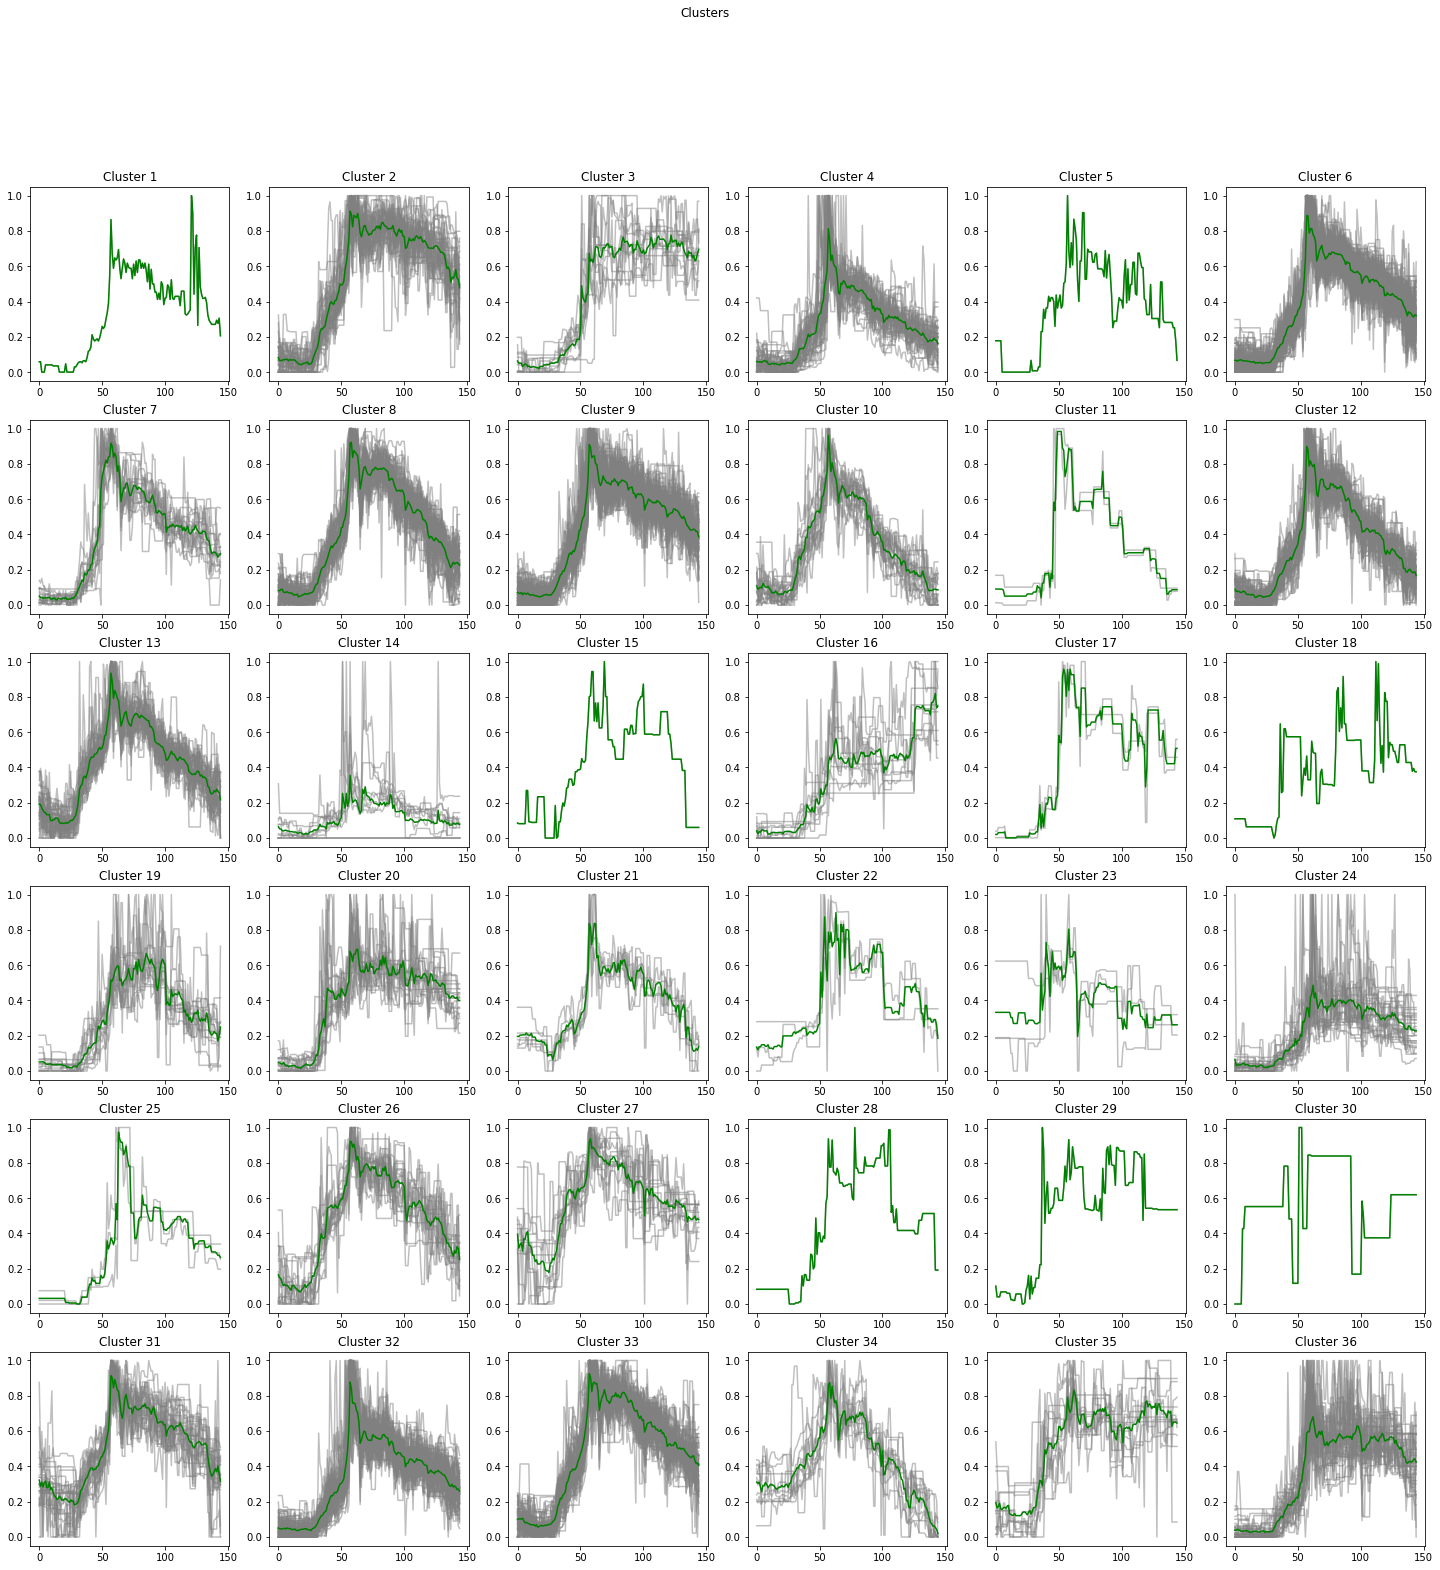

In [10]:
win_map = som.win_map(array_price_scaled)

plot_som_series_averaged_center(som_x, som_y, win_map)

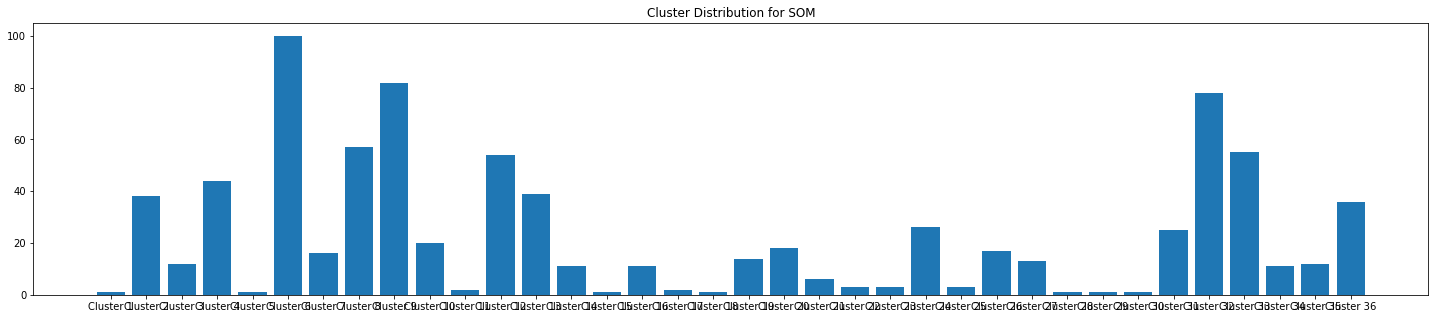

In [11]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

<br>시계열이 시각적으로도 잘 구분을 못함<br/>
<br>위아래로의 등락이 너무 Chaotic하기 때문이라고 판단.<br/>
<br>특히 뮤직카우의 경우 유동성이 충분하지 않기 때문에 적절한 균형가격에 Optimize되지 않는 문제<br/>
<br>Smoothing을 통해 다시 분류<br/>

In [ ]:
array_price_scaled = 

In [12]:
cluster_map = []
for idx in range(len(array_price_scaled)):
    winner_node = som.winner(array_price_scaled[idx])
    cluster_map.append((list_price_droped[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

df_cluster = pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

In [13]:
conn = DbEnv().connect_mongo('music_cow', 'daily_music_cow')

In [14]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 1"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['1375']
title: A Door --- artist: 권순관


In [15]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 2"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['702', '705', '1259', '1184', '591', '1109', '590', '86', '94', '587', '491', '489', '961', '97', '708', '926', '723', '948', '125', '630', '1368', '835', '118', '659', '39', '1067', '655', '1423', '564', '1071', '45', '46', '154', '532', '1076', '1087', '147', '753']
title: Perhaps Love --- artist: 에릭남
title: 한번만... --- artist: 혜령
title: haaAakkKKK!!! --- artist: OurR
title: DREAMLIKE --- artist: IZ*ONE
title: 희나리 --- artist: 구창모
title: 일년을 하루같이 --- artist: 바비 킴
title: 너를 사랑하고도 --- artist: 전유나
title: 보란듯이 --- artist: 손승연
title: 너란 봄 --- artist: 정은지
title: 하얀 바람 --- artist: 소방차
title: 내입술...따뜻한 커피처럼 --- artist: 샵
title: 미리 메리 크리스마스 --- artist: 아이유
title: 술 한잔 해요 --- artist: 지아
title: 거북이 --- artist: 다비치
title: 내가 먼저 --- artist: 도겸
title: 홀로 된다는 것 --- artist: 변진섭
title: 겨울이야기 --- artist: 조관우
title: 그리워하다 --- artist: 비투비
title: 죽도록 사랑해 --- artist: MC몽
title: 눈 내리는 마을 --- artist: 애프터스쿨
title: A Fool Moon Night --- artist: 칵스
title: 당신의 눈물 --- artist: 태진아
title: 죽을 만큼 아파서 --- artist: MC몽


In [16]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 3"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['1048', '178', '920', '27', '322', '42', '50', '60', '886', '515', '962', '420']
title: 편한 사람이 생겼어 --- artist: 일락
title: Simple Love --- artist: MC몽
title: 퇴근버스 --- artist: 이준호
title: 연애시대 --- artist: 이승기
title: 두근두근 --- artist: 김종민
title: 안녕 --- artist: 박혜경
title: Fly --- artist: SUPER JUNIOR-K.R.Y.
title: 다툼 --- artist: 제리케이
title: Must Have Love --- artist: 가인
title: 안녕 정말 안녕 --- artist: 엠투엠
title: 사랑은 언제나 목마르다 --- artist: 유미
title: 눈물 자국 --- artist: 김종국


In [17]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 4"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['1428', '68', '615', '164', '818', '612', '699', '740', '1056', '84', '697', '854', '700', '261', '671', '1012', '746', '674', '1016', '193', '761', '188', '596', '1208', '1193', '70', '1191', '934', '1050', '1378', '739', '1558', '1107', '872', '157', '710', '879', '1383', '631', '850', '117', '1380', '542', '703']
title: Sad --- artist: 손승연
title: White Day --- artist: 걸스데이
title: 제자리 걸음 --- artist: 고유진
title: So Fresh --- artist: MC몽
title: Hello --- artist: G-DRAGON
title: 다시 쓰고 싶어 --- artist: 에일리
title: Navy & Shining Gold --- artist: VIXX
title: 사랑의 시 --- artist: 엠씨더맥스
title: 사뿐사뿐 --- artist: AOA
title: 슬픔을 참는 세 가지 방법 --- artist: 혜령
title: D-Day --- artist: 정기고
title: HANDS UP --- artist: BIGBANG
title: Young 20 --- artist: 박지훈
title: 혼자가 편해졌어 --- artist: ELSIE
title: 와줘.. --- artist: SE7EN
title: 짧은 치마 --- artist: AOA
title: 첫사랑 --- artist: 오투포
title: 전할 수 없는 이야기 --- artist: 휘성
title: Boo --- artist: 아이유
title: 넌 달라 --- artist: DIA
title: OK --- artist: 딸기우유
title: 듣고싶어 --- art

In [18]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 5"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['1055']
title: 노는 게 제일 좋아 --- artist: 루나솔라


In [19]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 6"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['1348', '996', '1238', '1111', '1356', '1331', '1021', '211', '1019', '218', '1017', '1351', '133', '1008', '28', '1550', '132', '231', '1388', '1122', '78', '127', '1379', '175', '1221', '151', '1077', '1078', '91', '104', '1151', '107', '1089', '1381', '1181', '1369', '112', '146', '1140', '1510', '165', '59', '64', '1192', '140', '139', '173', '1090', '76', '667', '990', '569', '506', '566', '822', '470', '561', '844', '853', '991', '863', '539', '865', '949', '866', '936', '525', '923', '919', '509', '897', '898', '493', '494', '571', '815', '468', '771', '666', '656', '654', '685', '686', '688', '646', '645', '585', '716', '622', '691', '729', '965', '966', '594', '722', '744', '602', '618', '741', '902']
title: 여성시대 --- artist: 씨야
title: 나를 잊지마요 --- artist: 걸스데이
title: 난 좋아 --- artist: 정준일
title: Reason --- artist: 바비 킴
title: 아퍼 --- artist: 기리보이
title: 정상을 향한 독주 2 --- artist: 주석
title: Mad --- artist: 바다
title: 죽도록 사랑해 2 --- artist: MC몽
title: 불고... --- artist: 지아
title: 사랑 앞에서

In [20]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 7"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['524', '884', '871', '103', '759', '1075', '1440', '1421', '155', '1124', '1005', '1065', '485', '1032', '461', '1007']
title: 노래가 늘었어 --- artist: 에일리
title: ECLIPSE --- artist: GOT7
title: 얼음꽃 --- artist: 에일리
title: I Love U Oh Thank U --- artist: MC몽
title: 러브 델루나 --- artist: 태용
title: 메아리 --- artist: 김태우
title: 오늘밤은 어둠이 무서워요 --- artist: 10cm
title: Something --- artist: 강다니엘
title: 목소리 --- artist: 백지영
title: La La --- artist: 정세운
title: 질투나 --- artist: 거미
title: 눈물에 얼굴을 묻는다 --- artist: 장나라
title: I Like That --- artist: 씨스타
title: 내 마음의 사진 --- artist: 송가인
title: U & I --- artist: 에일리
title: 넌 is 뭔들 --- artist: 마마무


In [21]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 8"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['760', '768', '967', '770', '1185', '584', '906', '1285', '579', '460', '185', '1038', '549', '114', '115', '777', '754', '750', '1131', '676', '989', '652', '997', '1509', '37', '1506', '998', '1000', '1439', '983', '709', '624', '623', '976', '974', '745', '752', '1128', '582', '1126', '916', '895', '514', '1088', '885', '922', '537', '1103', '1104', '1105', '868', '134', '1044', '536', 0, '952', '174']
title: 난 예술이야 --- artist: 헬로비너스
title: Please --- artist: 플라워
title: 봄 --- artist: 박봄
title: FOR YOU --- artist: 플라워
title: 내 입술 따뜻한 커피처럼 --- artist: 에디킴
title: 떠날거야 --- artist: 쎄쎄쎄
title: 2U --- artist: 강다니엘
title: 내가 되었으면 --- artist: 노리플라이
title: 오직 하나뿐인 그대 --- artist: 심신
title: NoNoNo --- artist: Apink
title: 너에게 쓰는 편지 Part 2 --- artist: MC몽
title: 여기요 --- artist: 홍자
title: 진심 --- artist: 이예준
title: 반창고 --- artist: 허각
title: 짧은머리 --- artist: 허각
title: 잘 있나요 --- artist: The One
title: Another Day --- artist: 먼데이 키즈
title: 니 소식 --- artist: 송하예
title: 랑데뷰 --- artist: 양혜승
title: 고백 --

In [22]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 9"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['511', '695', '44', '847', '179', '516', '1438', '547', '982', '262', '721', '977', '620', '727', '857', '1013', '1427', '1082', '987', '731', '993', '665', '994', '1546', '156', '1542', '496', '32', '1072', '988', '899', '914', '36', '119', '487', '648', '161', '1080', '616', '1117', '610', '1188', '82', '775', '484', '474', '158', '783', '789', '1113', '106', '573', '1115', '95', '189', '955', '821', '565', '963', '964', '1108', '81', '743', '373', '142', '1097', '925', '1350', '471', '756', '1157', '1344', '969', '968', '859', '80', '1121', '1230', '554', '558', '79', '163']
title: 봄처럼 --- artist: 김보경
title: 만약에 우리 둘 중 하나라도 --- artist: 화요비
title: Yesterday --- artist: 박혜경
title: 미안해요 --- artist: 거미
title: 유리 심장 --- artist: 린
title: 여자라서 --- artist: 아이유
title: 카페에 앉아 --- artist: 원 모어 찬스
title: 마주치지 말자 --- artist: SUPER JUNIOR
title: 응급실 --- artist: izi
title: Marry Me --- artist: 케이윌
title: 휴식같은 친구 --- artist: 김민우
title: 일기장 --- artist: 이승철
title: 영원한 사랑 --- artist: 핑클
title: 넌 또 다른

In [23]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 10"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['874', '529', '1160', '204', '1172', '1047', '1046', '781', '829', '1025', '951', '1169', '1508', '1539', '553', '1551', '1545', '1130', '1540', '1014']
title: 사랑했다 미워했다 --- artist: 황치열
title: 궁금해 --- artist: 모모랜드
title: 흩어진 나날들 --- artist: 강수지
title: 니가 필요해 --- artist: 베스티
title: 좋은 이별이 있을 리가 없잖아 --- artist: MC몽
title: 출 --- artist: 리사
title: SEDANSOGU --- artist: 수호
title: LOVE DAY --- artist: 양요섭
title: 시간이 필요해 --- artist: 김재환
title: 4시 44분 --- artist: 박봄
title: Ice Cream --- artist: 현아
title: O Sole Mio --- artist: IZ*ONE
title: 바람고개 --- artist: 진해성
title: 날 보러와요 --- artist: 오유진
title: 왠지 --- artist: DIA
title: 너를 --- artist: 이우
title: 이별에 아파하기 싫어 --- artist: 백지영
title: 퍼즐 --- artist: 용주
title: 보통 같으면 --- artist: 한동근
title: EVERYDAY I LOVE YOU --- artist: 이달의소녀


In [24]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 11"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['183', '765']
title: PIPPI --- artist: 투아이즈
title: 처음사랑 --- artist: 유열


In [25]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 12"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['734', '1114', '632', '1010', '586', '1102', '706', '911', '499', '1202', '668', '915', '954', '1134', '477', '621', '478', '956', '110', '1149', '1156', '1159', '1346', '101', '100', '462', '917', '913', '225', '692', '576', '556', '675', '557', '41', '842', '677', '568', '1422', '1053', '505', '160', '528', '1062', '1420', '605', '121', '769', '767', '649', '1377', '1093', '887', '889']
title: 행복하지 말아요 --- artist: 엠씨더맥스
title: 너의 곁에 --- artist: 변진섭
title: 우리 사랑 여기까지죠 --- artist: 혜령
title: 장난아냐 --- artist: 틴탑
title: 통화중 --- artist: 소방차
title: Don't Cry --- artist: 더 크로스
title: 기억속의 먼 그대에게 --- artist: 박효신
title: 저기요 --- artist: 하성운
title: 꽃이야 --- artist: JBJ
title: 연애 같은 걸 하니까 --- artist: 소란
title: With Me --- artist: 휘성
title: 오빠만 믿어 --- artist: 박현빈
title: Dream Girls --- artist: 아이오아이
title: Wake Up --- artist: 일레인
title: Amen --- artist: 몬스타엑스
title: 게임의 법칙 --- artist: 구피
title: 솔직히 말할까 --- artist: 몬스타엑스
title: 이름이 뭐예요? --- artist: 4minute
title: 미치겠어 --- artist: MC몽
title: 그대가 나를 

In [26]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 13"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['1035', '1027', '598', '219', '124', '1084', '1024', '755', '958', '758', '603', '733', '737', '959', '766', '1127', '265', '99', '950', '663', '555', '838', '839', '559', '869', '877', '878', '881', '883', '683', '891', '892', '578', '1031', '1029', '488', '1186', '910', '1152']
title: 오늘 뭐해?! --- artist: 하성운
title: 빙글빙글 --- artist: 유키스
title: Go Higher --- artist: GOT7
title: 마카롱 --- artist: 걸스데이
title: 하늘색 약속 --- artist: god
title: Pretty --- artist: IZ*ONE
title: 뛰뛰빵빵 --- artist: 비투비
title: 나랑 사귈래 --- artist: DIA
title: 잊지마요 --- artist: 하성운
title: Go&Stop --- artist: ASTRO
title: 여름여름해 --- artist: 여자친구
title: Really Like You --- artist: IZ*ONE
title: 365일 --- artist: 알리
title: 문득 --- artist: 하성운
title: SOUL --- artist: H&D
title: 나도 모르는 노래 --- artist: 김필
title: 나쁜손 --- artist: 씨스타
title: Something --- artist: 걸스데이
title: 심쿵해 --- artist: AOA
title: BIRD --- artist: 하성운
title: SHAKE IT --- artist: 씨스타
title: 샤넬 --- artist: MC몽
title: 온도 --- artist: MC몽
title: BAAM --- artist: 모모랜드
t

In [27]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 14"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['526', '1070', '191', '909', '212', '901', '836', '77', '238', '1018', '813']
title: 꿈에 --- artist: EXID
title: WE LIKE 2 PARTY --- artist: BIGBANG
title: 진통제 --- artist: 티아라
title: 아미가르 레스토랑 --- artist: 쎄쎄쎄
title: 마녀가 된 이유 --- artist: NS 윤지
title: 목격자 --- artist: 박지윤
title: 그대 내 친구여 --- artist: 패티김
title: 별빛 바램 --- artist: SHINee
title: 보고싶어 --- artist: 걸스데이
title: Peek-A-Boo --- artist: 박규리
title: BABY DON'T CRY --- artist: 대성


In [28]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 15"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['472']
title: 사랑해 --- artist: 마이티 마우스


In [29]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 16"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['47', '33', '168', '947', '49', '55', '83', '817', '893', '575', '592']
title: 가슴앓이 --- artist: 바비 킴
title: Couple Song --- artist: 라디
title: IF... --- artist: B1A4
title: 불꽃처럼 --- artist: JBJ95
title: 기억할게요 --- artist: 양파
title: Tic Toc --- artist: 매드클라운
title: 소원 --- artist: 김현성
title: No Woman No Cry --- artist: 스토니 스컹크
title: 너를 사랑하진 않아 --- artist: 자이언트핑크
title: 겁나 --- artist: 멜로디데이
title: 욕심쟁이 --- artist: 심신


## 2. Dynamic Time Warping Barycenter Averaging (DBA)

In [32]:
from copy import deepcopy
from scipy import interpolate
import numpy as np
from dtaidistance import dtw
import matplotlib.pyplot as plt
from _plotly_future_ import v4_subplots
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [33]:
NUM_OF_TRAJECTORIES = 200
MIN_LEN_OF_TRAJECTORY = 16
MAX_LEN_OF_TRAJECTORY = 40
THRESHOLD = 0.50

https://towardsdatascience.com/time-series-hierarchical-clustering-using-dynamic-time-warping-in-python-c8c9edf2fda5

In [ ]:
array_price_scaled = deepcopy(array_price_scaled)
distanceMatrixDictionary = {}
iteration = 1
while True:
   distanceMatrix = np.empty((len(array_price_scaled), len(array_price_scaled),))
   distanceMatrix[:] = np.nan
   
   for index1, (filter1, trajectory1) in enumerate(trajectories.items()):
      tempArray = []
      
      for index2, (filter2, trajectory2) in enumerate(trajectories.items()):
         
         if index1 > index2:
            continue
         
         elif index1 == index2:
            continue
         
         else:
            unionFilter = filter1 + filter2
            sorted(unionFilter)
            
            if unionFilter in distanceMatrixDictionary.keys():
               distanceMatrix[index1][index2] = distanceMatrixDictionary.get(unionFilter)
               
               continue
            
            metric = []
            for subItem1 in trajectory1:
               
               for subItem2 in trajectory2:
                  metric.append(dtw.distance(subItem1, subItem2, psi=1))
            
            metric = max(metric)
            
            distanceMatrix[index1][index2] = metric
            distanceMatrixDictionary[unionFilter] = metric